<center><h1>Structural Time Series modeling in TensorFlow Probability</h1></center>

# 0. Prelim

## 0.1 Packages

### Python

In [1]:
560/7774

0.0720349884229483

In [52]:
from pathlib import Path

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

import tensorboard
from matplotlib import pyplot as plt

### Jupyter

In [2]:
%load_ext tensorboard

## 0.2 Paths

In [3]:
DATA_FOLDER = Path("../../data")
RAW_DATA_FOLDER = DATA_FOLDER / "raw"

## 0.3 Parameters

In [9]:
num_variational_steps = int(200)

## 0.4 Functions

In [49]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

# 1. Data

Text(0.5, 1.0, 'Monthly avearge CO2 concentration, Mauna Loa, Hawaii')

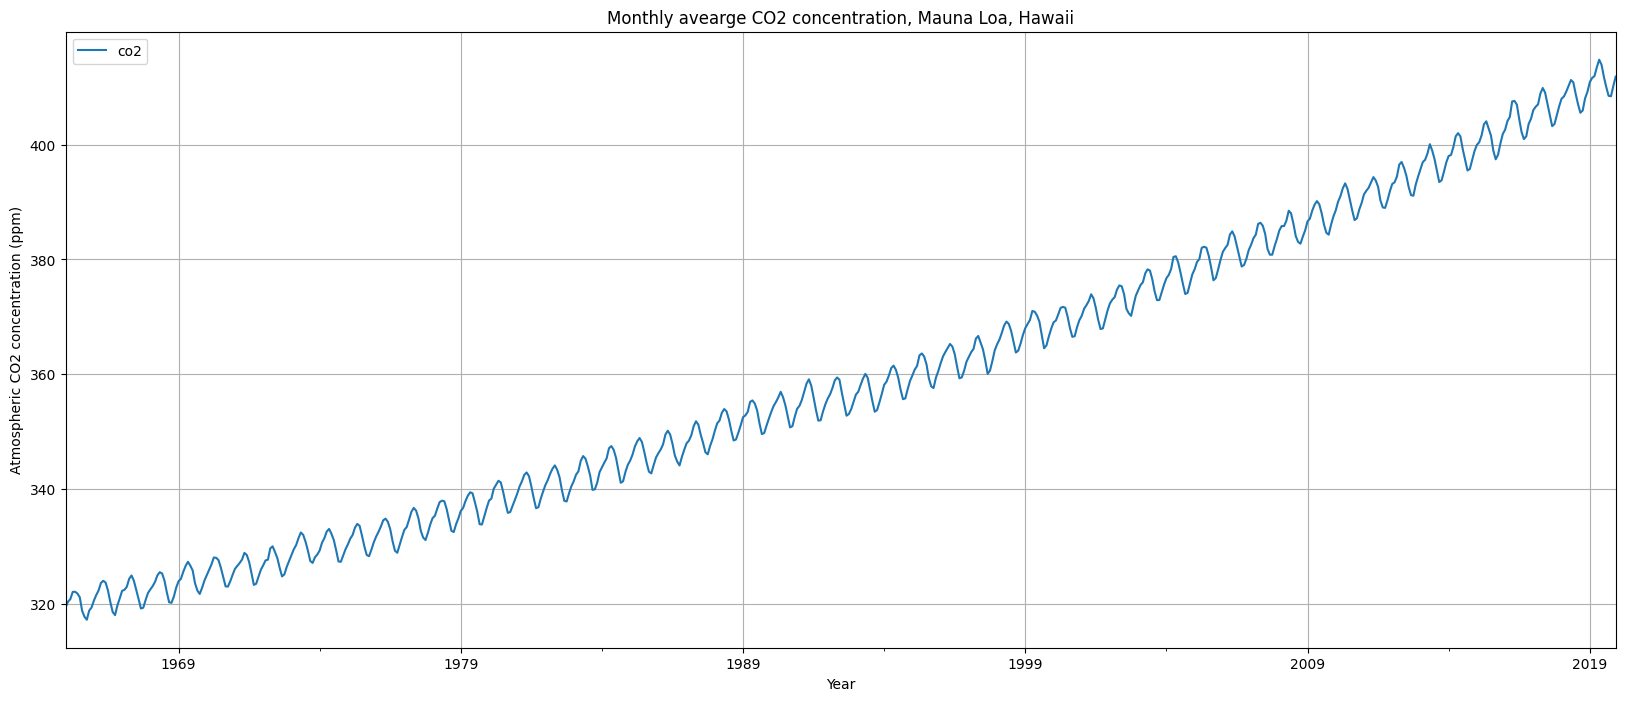

In [4]:
# A. Extract Data
df_co2_by_month = pd.read_csv(
    RAW_DATA_FOLDER / "monthly_in_situ_co2_mlo.csv",
    skiprows=56, header=[1,2,3]
)

# B. Data Transformation
# B1. Select Columns
df_co2_by_month.columns = [(col[0].strip(), col[1].strip()) for col in df_co2_by_month.columns]
df_co2_by_month = df_co2_by_month.loc[: , [('Yr',''), ('Mn',''), ('CO2','')]]
df_co2_by_month.columns = [col[0].strip() for col in df_co2_by_month.columns]
# B2. Create Date Column
df_co2_by_month.rename(columns={'Yr' : 'year', 'Mn' : 'month', 'CO2' : 'co2'}, inplace=True)
df_co2_by_month['day'] = 1
df_co2_by_month['month_dt'] = pd.to_datetime(df_co2_by_month[['year', 'month','day']])
df_co2_by_month.drop(columns=['year', 'month', 'day'], inplace=True)
# B3. Define Date Column as Index
df_co2_by_month.set_index('month_dt', inplace=True)
# B4. Resampling
df_co2_by_month = df_co2_by_month.resample("M").mean()
# B4. Remove Dates
df_co2_by_month = df_co2_by_month['1965-01-01':'2019-12-31']

# C. Display
# C1. Figure
fig, ax = plt.subplots(figsize=(20,8))
# C2. Plot
df_co2_by_month.plot(ax=ax)
# C3. Format
ax.grid(True)
ax.set_xlabel('Year')
ax.set_ylabel('Atmospheric CO2 concentration (ppm)')
ax.set_title("Monthly avearge CO2 concentration, Mauna Loa, Hawaii")

# 2. Prepare Data

In [5]:
# A. Train/Test-Split
df_co2_by_month_training_data = df_co2_by_month[:'2010-01-01']
df_co2_by_month_test_data = df_co2_by_month['2010-01-01':]

# 2. Modeling

## 2.1 Local Linear Trend

### Build the Model

In [6]:
# A. Define TS Components
trend = tfp.sts.LocalLinearTrend(
    observed_time_series=df_co2_by_month_training_data
    )
seasonal = tfp.sts.Seasonal(
    num_seasons=12, 
    observed_time_series=df_co2_by_month_training_data
    )

# B. Define additive TS model
co2_model = tfp.sts.Sum(
    [trend, seasonal],
    observed_time_series=df_co2_by_month_training_data
    )

2023-09-20 02:46:44.590240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-20 02:46:44.590675: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Train the Model

Text(0.5, 1.0, 'ELBO(q) Development\n$E_{q(z)}[\\log p(z,x)]-E_{q(z)}[\\log q(z)]$')

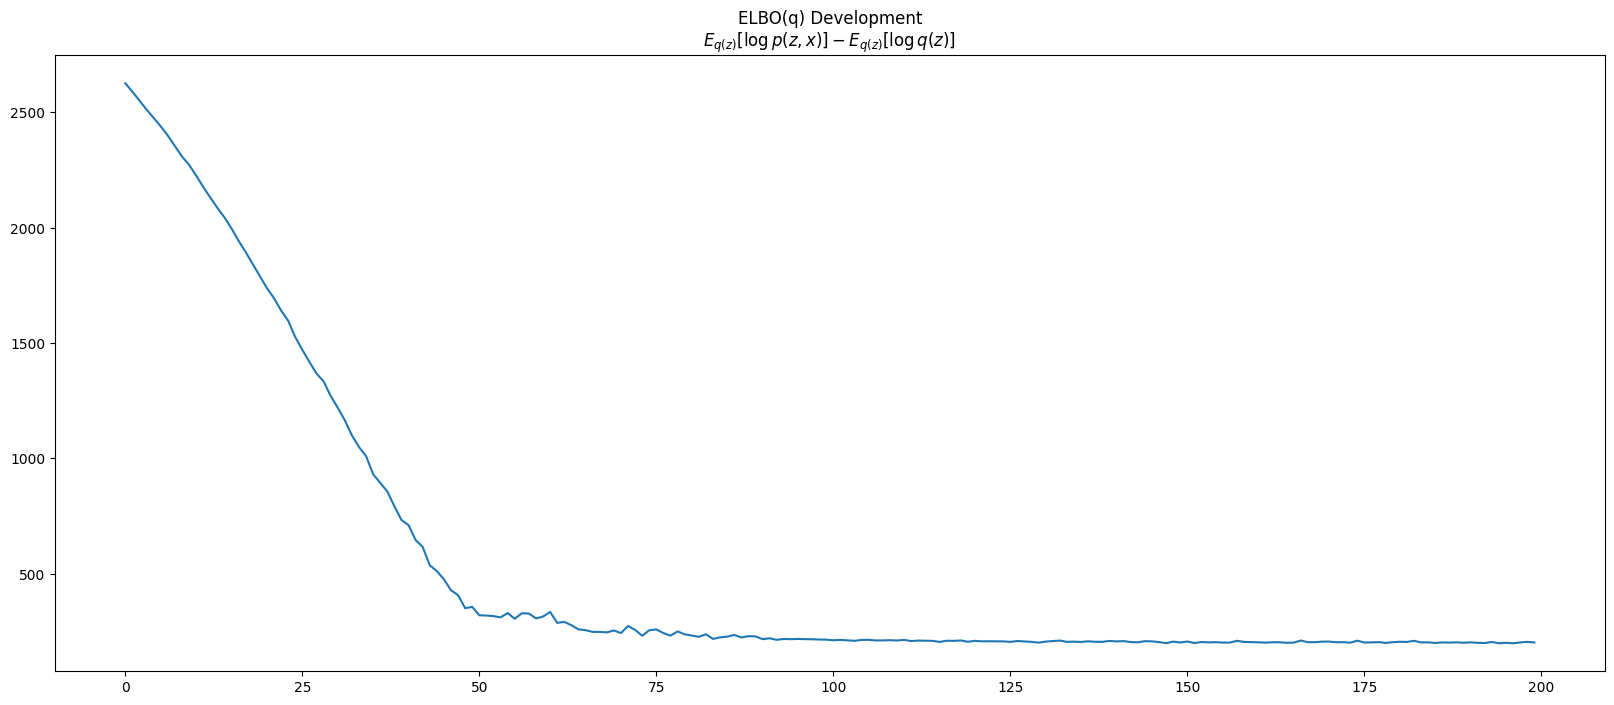

In [15]:
# Build Variational Posterior Object
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=co2_model
)

# Optimize the Variational Posterior.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=co2_model.joint_distribution(
        observed_time_series=df_co2_by_month_training_data
        ).log_prob,
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True
)

### Evaluation

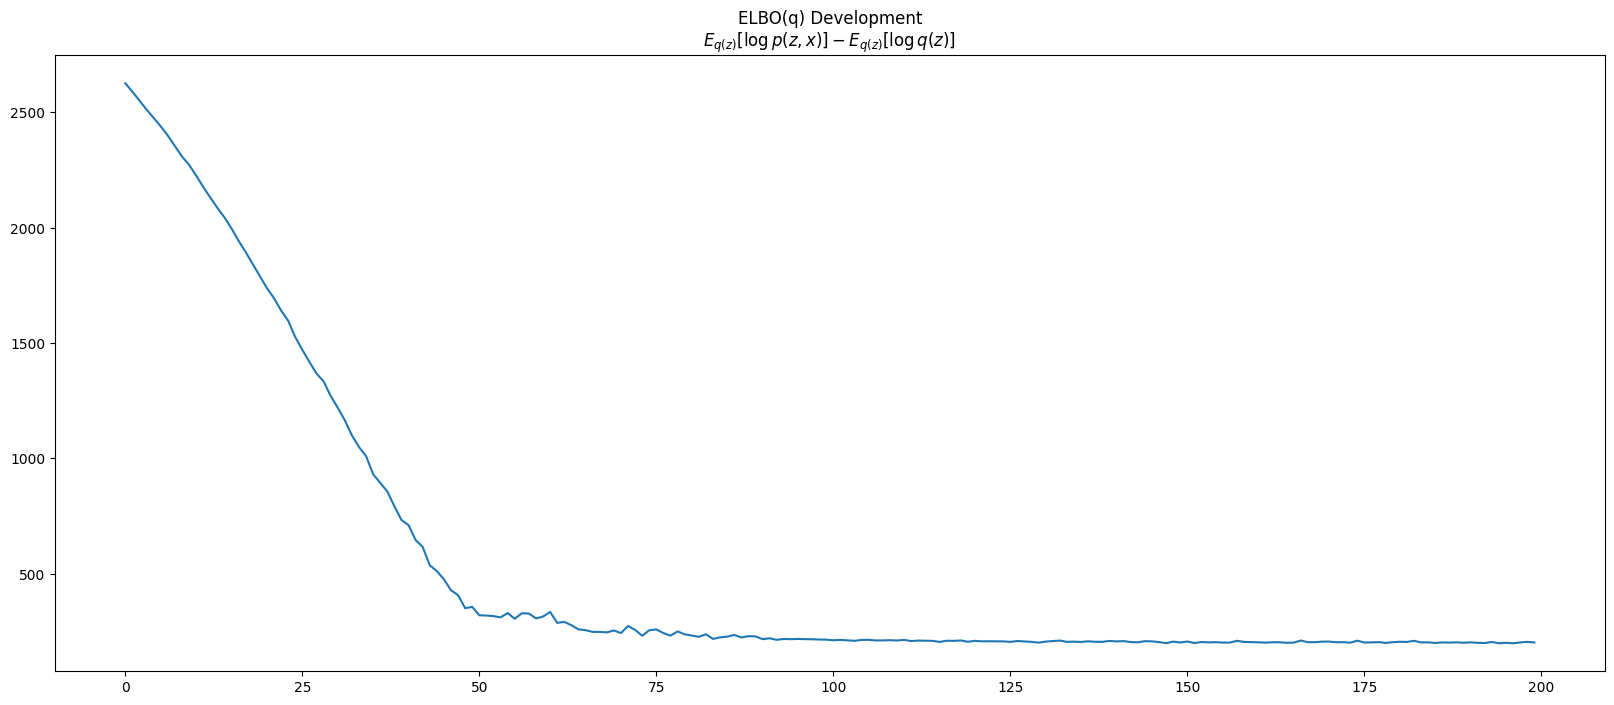

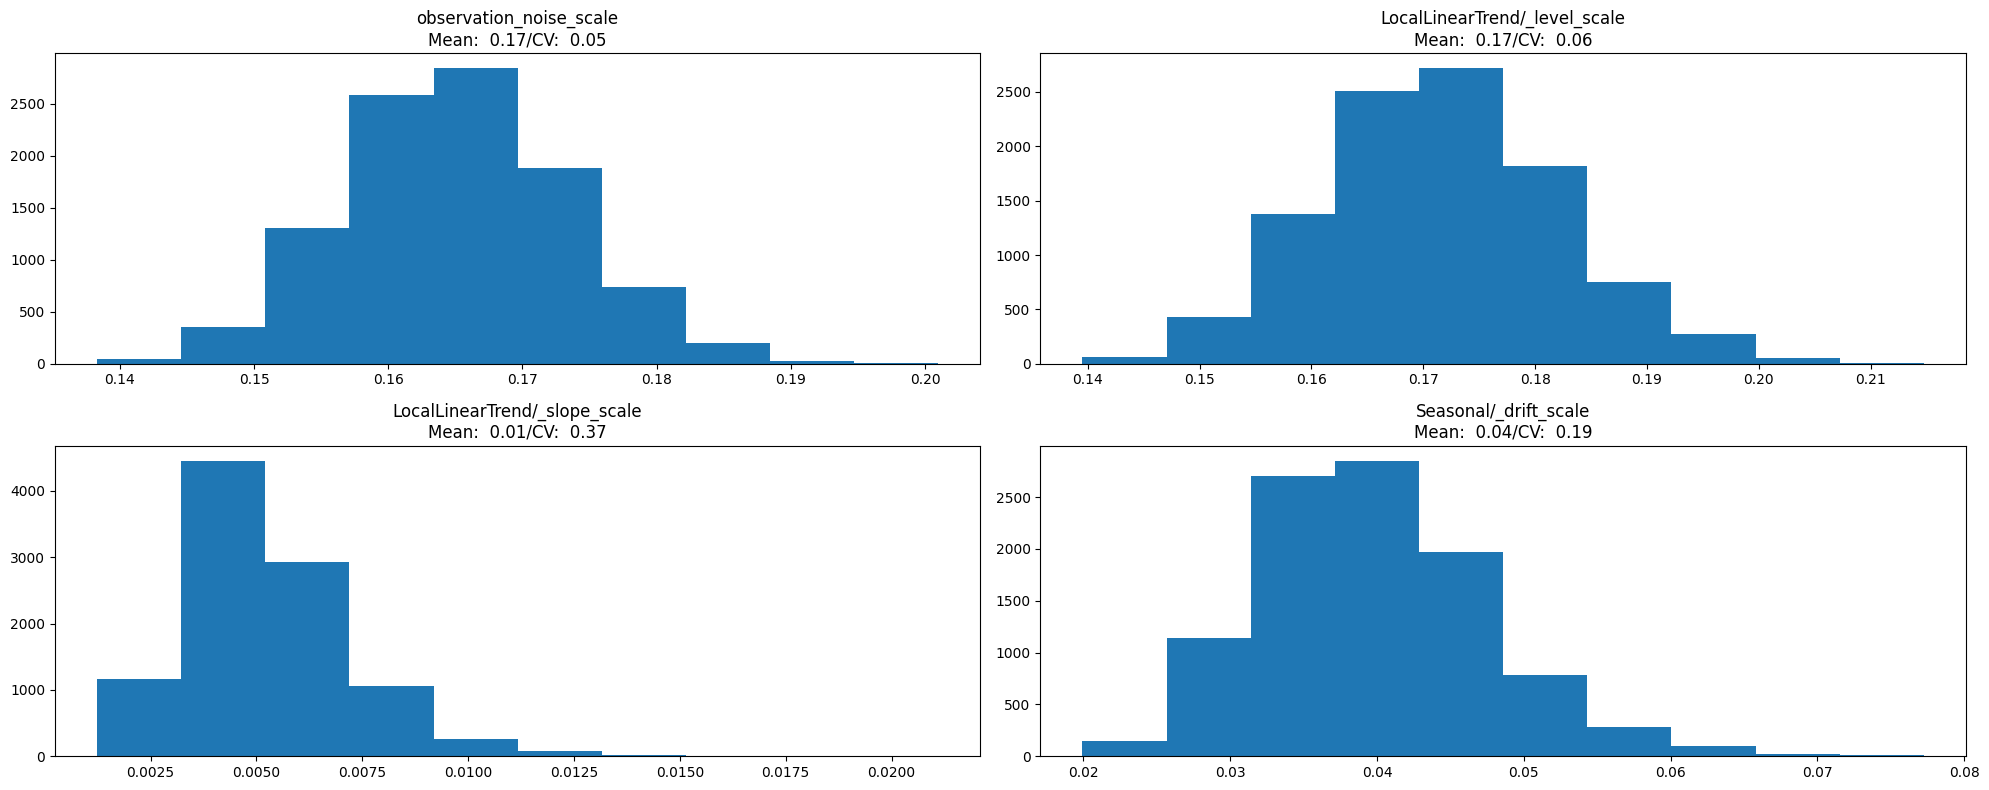

In [45]:
# A. Loss Function
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(elbo_loss_curve)
ax.set_title("ELBO(q) Development\n$E_{q(z)}[\log p(z,x)]-E_{q(z)}[\log q(z)]$")
plt.show()

# B. Model Parameter Distribution
param_samples = variational_posteriors.sample(10_000)
fig, axs = plt.subplots(2,2,figsize=(20,8))
axs = axs.flatten()
for param_nr, param in enumerate(co2_model.parameters):
    param_mean = np.mean(param_samples[param.name], axis=0)
    param_std = np.std(param_samples[param.name], axis=0)
    axs[param_nr].hist(param_samples[param.name].numpy())
    axs[param_nr].set_title(f'{param.name}\nMean: {param_mean : .2f}/CV: {param_std/param_mean : .2f}')
fig.tight_layout()

### Forecasting

In [60]:
co2_forecast_dist.sample(100).numpy().shape

<tf.Tensor: shape=(100, 120, 1), dtype=float64, numpy=
array([[[388.43167047],
        [389.26924001],
        [390.0946042 ],
        ...,
        [401.40993125],
        [403.0483541 ],
        [404.37790316]],

       [[388.84473611],
        [389.77182036],
        [390.3600303 ],
        ...,
        [402.65351258],
        [403.98963306],
        [405.04230454]],

       [[388.64776644],
        [389.06092872],
        [389.92396269],
        ...,
        [411.77973282],
        [413.40470641],
        [415.20003679]],

       ...,

       [[388.56835613],
        [388.80944982],
        [389.64025853],
        ...,
        [397.77529636],
        [399.28317651],
        [400.84238037]],

       [[388.67345738],
        [388.97135562],
        [390.04431181],
        ...,
        [402.63716768],
        [403.87440871],
        [405.69107829]],

       [[388.15634838],
        [389.69922139],
        [390.42668784],
        ...,
        [407.32945127],
        [408.78270948],
    

In [48]:
co2_forecast_dist = tfp.sts.forecast(
    co2_model,
    observed_time_series=df_co2_by_month_training_data,
    parameter_samples=param_samples,
    num_steps_forecast=120
)



num_samples=10

co2_forecast_mean, co2_forecast_scale, co2_forecast_samples = (
    co2_forecast_dist.mean().numpy()[..., 0],
    co2_forecast_dist.stddev().numpy()[..., 0],
    co2_forecast_dist.sample(num_samples).numpy()[..., 0])
     


In [55]:
df_co2_by_month

,co2
month_dt,
1965-01-31,319.44
1965-02-28,320.45
1965-03-31,320.89
1965-04-30,322.14
1965-05-31,322.17
...,...
2019-08-31,410.01
2019-09-30,408.48
2019-10-31,408.40


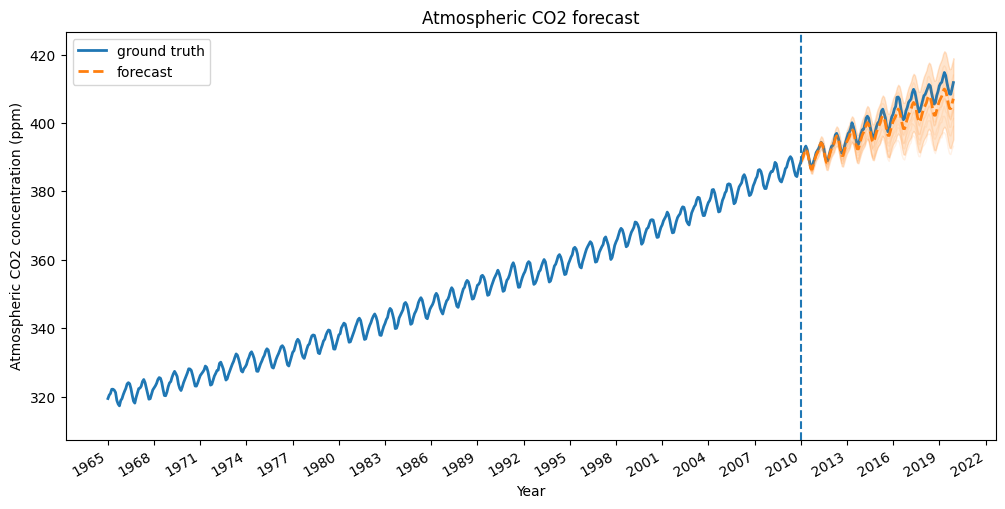

In [57]:
import matplotlib.dates as mdates
import seaborn as sns
co2_dates = np.arange("1965-01", "2020-01", dtype="datetime64[M]")
co2_loc = mdates.YearLocator(3)
co2_fmt = mdates.DateFormatter('%Y')
fig, ax = plot_forecast(
    co2_dates,  df_co2_by_month,
    co2_forecast_mean, co2_forecast_scale, co2_forecast_samples,
    x_locator=co2_loc,
    x_formatter=co2_fmt,
    title="Atmospheric CO2 forecast")
ax.axvline(co2_dates[-12*10], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_xlabel("Year")
fig.autofmt_xdate()

In [10]:
co2_forecast_dist.sample(10).numpy()

InvalidArgumentError: Graph execution error:

Detected at node 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/TensorArrayV2Stack_1/TensorListStack' defined at (most recent call last):
    File "/home/micha/.asdf/installs/python/3.9.16/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/micha/.asdf/installs/python/3.9.16/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1046, in launch_instance
      app.start()
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/micha/.asdf/installs/python/3.9.16/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/micha/.asdf/installs/python/3.9.16/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/micha/.asdf/installs/python/3.9.16/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_521/2516328157.py", line 6, in <module>
      co2_forecast_dist.sample(num_samples).numpy()[..., 0])
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1205, in sample
      return self._call_sample_n(sample_shape, seed, **kwargs)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1182, in _call_sample_n
      samples = self._sample_n(
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/mixture_same_family.py", line 284, in _sample_n
      x = components_distribution.sample(  # [n, B, k, E]
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1205, in sample
      return self._call_sample_n(sample_shape, seed, **kwargs)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1182, in _call_sample_n
      samples = self._sample_n(
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/linear_gaussian_ssm.py", line 721, in _sample_n
      _, observation_samples = self._joint_sample_n(n, seed=seed)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/linear_gaussian_ssm.py", line 733, in _joint_sample_n
      return self._joint_sample_n_sequential(n, seed=seed)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/linear_gaussian_ssm.py", line 787, in _joint_sample_n_sequential
      (latents, observations, _) = tf.scan(
Node: 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/TensorArrayV2Stack_1/TensorListStack'
Tried to stack elements of an empty list with non-fully-defined element_shape: [?,50,1,1]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/TensorArrayV2Stack_1/TensorListStack}}]] [Op:__inference_sample_25838]

In [7]:


num_samples=10

co2_forecast_mean, co2_forecast_scale, co2_forecast_samples = (
    co2_forecast_dist.mean().numpy()[..., 0],
    co2_forecast_dist.stddev().numpy()[..., 0],
    co2_forecast_dist.sample(num_samples).numpy()[..., 0])
     


InvalidArgumentError: Graph execution error:

Detected at node 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/TensorArrayV2Stack_1/TensorListStack' defined at (most recent call last):
    File "/home/micha/.asdf/installs/python/3.9.16/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/micha/.asdf/installs/python/3.9.16/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1046, in launch_instance
      app.start()
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/micha/.asdf/installs/python/3.9.16/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/micha/.asdf/installs/python/3.9.16/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/micha/.asdf/installs/python/3.9.16/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_521/2516328157.py", line 6, in <module>
      co2_forecast_dist.sample(num_samples).numpy()[..., 0])
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1205, in sample
      return self._call_sample_n(sample_shape, seed, **kwargs)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1182, in _call_sample_n
      samples = self._sample_n(
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/mixture_same_family.py", line 284, in _sample_n
      x = components_distribution.sample(  # [n, B, k, E]
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1205, in sample
      return self._call_sample_n(sample_shape, seed, **kwargs)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1182, in _call_sample_n
      samples = self._sample_n(
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/linear_gaussian_ssm.py", line 721, in _sample_n
      _, observation_samples = self._joint_sample_n(n, seed=seed)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/linear_gaussian_ssm.py", line 733, in _joint_sample_n
      return self._joint_sample_n_sequential(n, seed=seed)
    File "/home/micha/repos/liveprojects/ForecastingWithBayesianModeling/.venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/linear_gaussian_ssm.py", line 787, in _joint_sample_n_sequential
      (latents, observations, _) = tf.scan(
Node: 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/TensorArrayV2Stack_1/TensorListStack'
Tried to stack elements of an empty list with non-fully-defined element_shape: [?,50,1,1]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/TensorArrayV2Stack_1/TensorListStack}}]] [Op:__inference_sample_25838]

In [8]:


fig, ax = plot_forecast(
    co2_dates, co2_by_month,
    co2_forecast_mean, co2_forecast_scale, co2_forecast_samples,
    x_locator=co2_loc,
    x_formatter=co2_fmt,
    title="Atmospheric CO2 forecast")
ax.axvline(co2_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_xlabel("Year")
fig.autofmt_xdate()
     


NameError: name 'plot_forecast' is not defined